In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, KFold

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize images to 64x64
            images.append(img)
            if 'Closed_Eyes' in folder:
                labels.append(0)
            else:
                labels.append(1)
    return np.array(images), np.array(labels)

closed_eyes_path = '/home/adri/Documents/BDA/archive/train/Closed_Eyes'
open_eyes_path = '/home/adri/Documents/BDA/archive/train/Open_Eyes'

closed_eyes_images, closed_eyes_labels = load_images_from_folder(closed_eyes_path)
open_eyes_images, open_eyes_labels = load_images_from_folder(open_eyes_path)

images = np.concatenate((closed_eyes_images, open_eyes_images), axis=0)
labels = np.concatenate((closed_eyes_labels, open_eyes_labels), axis=0)

# Normalize the images
images = images / 255.0


Closed Eyes Images Shape: (2000, 64, 64, 3)
Closed Eyes Labels Shape: (2000,)
Open Eyes Images Shape: (2000, 64, 64, 3)
Open Eyes Labels Shape: (2000,)
All Images Shape: (4000, 64, 64, 3)
All Labels Shape: (4000,)


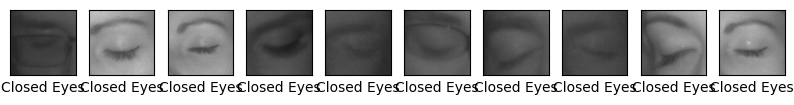

In [6]:
print("Closed Eyes Images Shape:", closed_eyes_images.shape)
print("Closed Eyes Labels Shape:", closed_eyes_labels.shape)
print("Open Eyes Images Shape:", open_eyes_images.shape)
print("Open Eyes Labels Shape:", open_eyes_labels.shape)
print("All Images Shape:", images.shape)
print("All Labels Shape:", labels.shape)

import matplotlib.pyplot as plt

def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        if labels[i] == 0:
            plt.xlabel('Closed Eyes')
        else:
            plt.xlabel('Open Eyes')
    plt.show()

# Display images and their labels
display_images(images, labels, num_images=10)



Closed Eyes Images Shape: (2000, 64, 64, 3)
Closed Eyes Labels Shape: (2000,)
Open Eyes Images Shape: (2000, 64, 64, 3)
Open Eyes Labels Shape: (2000,)
All Images Shape: (4000, 64, 64, 3)
All Labels Shape: (4000,)


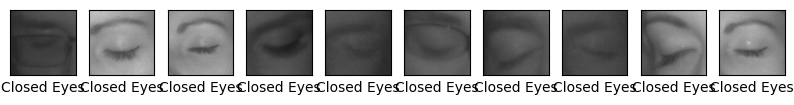

Epoch 1/10


/home/adri/Documents/BDA/archive/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6825 - loss: 0.5562 - val_accuracy: 0.8175 - val_loss: 0.4494
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8655 - loss: 0.3049 - val_accuracy: 0.8725 - val_loss: 0.4221
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9000 - loss: 0.2578 - val_accuracy: 0.8975 - val_loss: 0.2521
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9250 - loss: 0.2061 - val_accuracy: 0.8788 - val_loss: 0.3265
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9302 - loss: 0.1934 - val_accuracy: 0.9013 - val_loss: 0.2608
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9272 - loss: 0.1954 - val_accuracy: 0.9663 - val_loss: 0.1037
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9328 - loss: 0.1808 - val_accuracy: 0.9287 - val_loss: 0.1295
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9388 - loss: 0.1525 - val_accuracy: 0.927

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


kf = KFold(n_splits=5)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for train_index, val_index in kf.split(images):
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    datagen.fit(X_train)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(datagen.flow(X_train, y_train, batch_size=32), 
              epochs=10, 
              validation_data=(X_val, y_val),
              callbacks=[early_stopping])

model.save('/home/adri/Documents/BDA/drowsiness_model.keras')


In [11]:
import cv2
import tensorflow as tf
import numpy as np
import pygame
import threading

# Initialize pygame mixer
pygame.mixer.init()

# Load the alert sound
alert_sound = pygame.mixer.Sound('/home/adri/Documents/BDA/archive/siren-alert-96052.mp3')

# Load the model
model = tf.keras.models.load_model('/home/adri/Documents/BDA/drowsiness_model.keras')

# Start the webcam
cap = cv2.VideoCapture(0)

# Function to play sound
def play_sound():
    alert_sound.play()

# Function to stop sound
def stop_sound():
    alert_sound.stop()

# Counter to track closed eyes frames
closed_eyes_counter = 0
closed_eyes_threshold = 10  # Number of consecutive frames to trigger alert

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    resized_frame = cv2.resize(frame, (64, 64))
    normalized_frame = resized_frame / 255.0
    reshaped_frame = np.reshape(normalized_frame, (1, 64, 64, 3))

    # Make prediction
    prediction = model.predict(reshaped_frame)
    if prediction < 0.5:
        label = 'Closed Eyes'
        closed_eyes_counter += 1
    else:
        label = 'Open Eyes'
        closed_eyes_counter = 0
        stop_sound()

    # Trigger alert if closed eyes detected for consecutive frames
    if closed_eyes_counter >= closed_eyes_threshold:
        threading.Thread(target=play_sound).start()
        closed_eyes_counter = 0  # Reset counter after alert

    # Display the result
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Driver Drowsiness Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 